In [58]:
import numpy as np
from easyvec import Vec3, Mat3
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [72]:
class Target3D(object):
       
    @classmethod
    def get_simple_target(cls, pos, vel, aim, vel_aim, g=9.80665, dt=0.01):
        pos = cls._validate_dimension_argument(pos)
        vel = cls._validate_dimension_argument(vel)
        aim = cls._validate_dimension_argument(aim)
        vel_aim = cls._validate_dimension_argument(vel_aim)
        target = cls(pos=pos, vel=vel, aim=aim, vel_aim=vel_aim, g=g, dt=dt)
        parameters_simple_target = np.array([pos[0], pos[1], pos[2], vel[0], vel[1], vel[2], 0])
        target.set_init_cond(init_parametrs=parameters_simple_target)
        return target
    
    def __init__(self, **kwargs):
        self.g = kwargs['g']
        self.t = 0
        self.dt = kwargs['dt']
        
        self.A = kwargs['pos']
        self.D = kwargs['aim']
        self.velA = kwargs['vel'] 
        self.velD = kwargs['vel_aim']
        self.vel = self.velA
        
        self.n = 7
        self.state = np.zeros(self.n)
        self.state_init = np.zeros(self.n)
    
    @property
    def pos(self):
        return self.state[:3]
    
    @property
    def x(self):
        return self.pos[0]

    @property
    def y(self):
        return self.pos[1]
    
    @property
    def z(self):
        return self.pos[2]
    
    @property
    def vel_abs(self):
        return np.sqrt(self.vel.dot(self.vel))
    
    @property
    def vel_x(self):
        return self.vel[0]
    
    @property
    def vel_y(self):
        return self.vel[1]
    
    @property
    def vel_z(self):
        return self.vel[2]
    
    def set_init_cond(self, init_parametrs=None):
        if init_parametrs is None:
            init_parametrs = self.get_random_parameters_of_target()
        self.state = np.array(init_parametrs)
        self.state_init = np.array(init_parametrs)

    def get_random_parameters_of_target(self):
        # TODO
        pass
    
    def reset(self):
        self.set_state(self.state_init)

    def set_state(self, state):
        self.state = np.array(state)

    def get_state(self):
        return self.state
    
    def get_state_init(self):
        return self.state_init
    
    def get_B(self, fly_time):
        return self.A + (self.velA * fly_time / 3)
    
    def get_C(self, fly_time): 
        return self.D - (self.velD * fly_time / 3)
    
    def get_traject(self, fly_time, vel_trg=None, n_points=100):
        vel_trg = self.velD if vel_trg == None else vel_trg
        taus = np.linspace(0, 1, n_points)
        A, velA = self.pos, self.velA
        D, velD = self.D, vel_trg
        B = self.get_B(fly_time)
        C = self.get_C(fly_time)
        return np.array([
            (1-tau)**3 * A + 3*tau*(1-tau)**2 * B + 3*tau*tau*(1-tau)*C + tau**3 * D
            for tau in taus
        ])
    
    def get_traject_vels(self, fly_time, vel_trg=None, n_points=100):
        vel_trg = self.velD if vel_trg == None else vel_trg
        taus = np.linspace(0, 1, n_points)
        A, velA = self.pos, self.velA
        D, velD = self.D, vel_trg
        B = self.get_B(fly_time)
        C = self.get_C(fly_time)
        return np.array([
            (3*(1-tau)**2*(B-A) + 6*tau*(1-tau)*(C-B) + 3*tau**2*(D-C)) / fly_time
            for tau in taus
        ])
    
    def get_traject_acc(self, fly_time, vel_trg=None, n_points=100):
        vel_trg = self.velD if vel_trg == None else vel_trg
        taus = np.linspace(0, 1, n_points)
        A, velA = self.pos, self.velA
        D, velD = self.D, vel_trg
        B = self.get_B(fly_time)
        C = self.get_C(fly_time)
        return np.array([
            6 * ((tau-1)*(B-A) + (1-2*tau)*(C-B) + tau*(D-C)) / fly_time**2
            for tau in taus
        ])
    
#     def get_amax(self, fly_time, vel_trg=None, g=Vec3(0, -9.80665, 0)):
#         vel_trg = self.velD if vel_trg == None else vel_trg
#         A, velA = self.pos, self.velA
#         D, velD = self.D, vel_trg
#         B = get_B(fly_time)
#         C = get_C(fly_time)
#         a1 = (C - B) * 6 - (B - A) * 6 - g
#         a2 = (D - C) * 6 - (C - B) * 6 - g
#         return np.fmax(a1.len(), a2.len()) / (fly_time**2)
    
    def to_dict(self):
        return { 
            't': self.t,
            'x': self.x,
            'y': self.y,
            'z': self.z,
            'v': self.vel_abs,
            'vx': self.vel[0],
            'vy': self.vel[1],
            'vz': self.vel[2]
        }
    
    @staticmethod
    def _validate_dimension_argument(array, n=3):
        if len(array) == 0:
            return Vec3(0,0,0)            
        elif len(array) == n:
            try:
                l = [float(elem) for elem in array]
            except ValueError:
                raise ValueError("Один или несколько элементов в <{!r}> не действительное(-ые) число(-а)".format(seq))
            else:
                arg1, arg2, arg3 = l
                return Vec3(arg1, arg2, arg3)  
        else:
            raise ValueError("Неожиданное число элементов. Получено: {}, Ожидалось: {}.".format(len(array), n))  

In [73]:
target = Target3D.get_simple_target(pos=Vec3(5e3, 1e3, 300),
                                    vel=Vec3(-100, -100, -10),
                                    aim=Vec3(100,100,0),
                                    vel_aim=Vec3(-100,-10,0))

In [74]:
def get_traject(target, fly_time):
    traject = target.get_traject(fly_time)
    x = [i[0] for i in traject]
    y = [i[1] for i in traject]
    z = [i[2] for i in traject]
    return x, y, z

In [75]:
fly_times = np.linspace(10, 50, 5)

In [63]:
%matplotlib inline

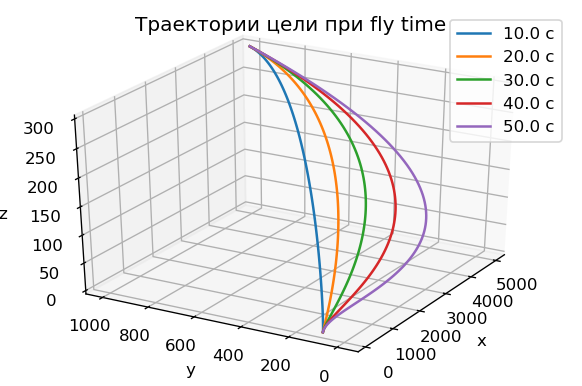

In [64]:
fig = plt.figure(dpi=120)
ax = plt.axes(projection='3d')
for fly_time in fly_times:
    x, y, z = get_traject(target, fly_time)
    ax.plot(x, y, z, label=f'{fly_time} c')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Траектории цели при fly time')
ax.view_init(elev=30, azim=-150)
ax.legend()
plt.show()

In [68]:
def get_traject_vels(target, fly_time):
    vtraject = target.get_traject_vels(fly_time)
    vx = [i[0] for i in vtraject]
    vy = [i[1] for i in vtraject]
    vz = [i[2] for i in vtraject]
    return vx, vy, vz

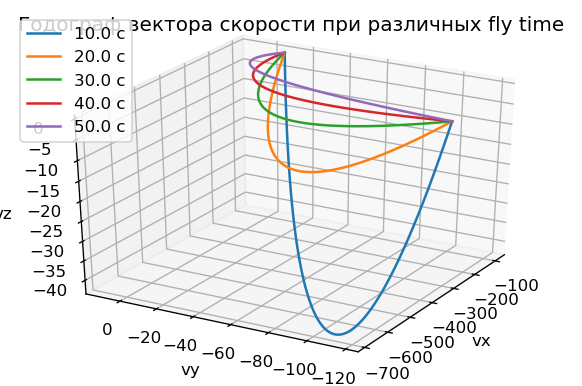

In [69]:
fig = plt.figure(dpi=120)
ax = plt.axes(projection='3d')
for fly_time in fly_times:
    x, y, z = get_traject_vels(target, fly_time)
    ax.plot(x, y, z, label=f'{fly_time} c')
ax.set_xlabel('vx')
ax.set_ylabel('vy')
ax.set_zlabel('vz')
ax.set_title('Годограф вектора скорости при различных fly time')
ax.view_init(elev=30, azim=-150)
ax.legend()
plt.show()

In [70]:
def get_traject_acc(target, fly_time):
    atraject = target.get_traject_acc(fly_time)
    ax = [i[0] for i in atraject]
    ay = [i[1] for i in atraject]
    az = [i[2] for i in atraject]
    return ax, ay, az

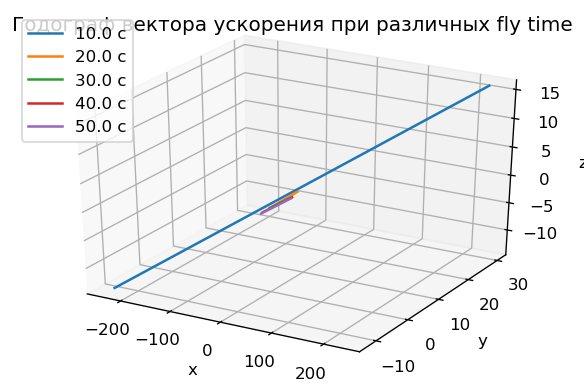

In [71]:
fig = plt.figure(dpi=120)
ax = plt.axes(projection='3d')
for fly_time in fly_times:
    x, y, z = get_traject_acc(target, fly_time)
    ax.plot(x, y, z, label=f'{fly_time} c')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Годограф вектора ускорения при различных fly time')
# ax.view_init(elev=30, azim=-150)
ax.legend()
plt.show()